# Convenience module for pytorch training

## Imports

In [1]:
import writefile_run

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%writefile_run train_utils.py


"""
Concenvience module for pytorch training and visualization.
"""

import torch
import torch.nn as nn
from torch import optim
from pylab import *
from torch.utils.data import *
from IPython.display import *
from nb_figure import *
import os, time

In [4]:
style.use(['dark_background'])
rcParams['axes.grid']=True
rcParams['font.size']=15
rcParams['figure.figsize']=18,7

In [5]:
%%writefile_run train_utils.py -a


def getTimeName():
    """Return the current time in format <day>-<month>_<hour><minute> for use in filenames."""
    from datetime import datetime
    t = datetime.now()
    return "{:02d}-{:02d}_{:02d}{:02d}".format(t.day,t.month,t.hour,t.minute)

In [6]:
%%writefile_run train_utils.py -a


def decorate_plot(axes):
    """Label axes and title for loss plot"""
    ax = axes[0][0]
    ax.set_title("Training loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

In [7]:
%%writefile_run train_utils.py -a


def trainLoop(model, train_loader, optimizer, trainOnBatch, epochs=10, 
              save_every=1, save_dir=None, batch_interval=10, scheduler=None):
    """
    Run a train loop for the given model with a dynamic loss graph.
    The model checkpoints are saved in a directory called run_<timestamp> under the
    given save directory. Model state dicts are checkpointed. The raw model, as well as the
    list of losses for each epoch are saved after the completion of training or 
    if training is interrupted. The list of losses is also returned after training.
    
    Arguments:
    ---------------
    model: The model to be trained
    train_loader: The DataLoader object to be iterated over
    optimizer: The optimizer to be used for training
    trainOnBatch: A function with the following signature:
        trainOnBatch(model,batch,optimizer). It should return
        a tensor containing the loss for that batch.
    
    epochs: Number of epochs
    save_every: Number of epochs between model saves
    save_dir: The top level directory for saving
    batch_interval: The number of batches between display updates
    scheduler: A learning rate scheduler which steps on the loss at 
        every epoch
    ---------------
    
    """
    
    """Set up directories"""
    run_dir = "run_{}".format(getTimeName())

    if save_dir==None:
        save_dir=type(model).__name__
    
    os.makedirs(os.path.join(save_dir,run_dir),exist_ok=True)
    
    """Set up IPython displays"""
    # First line display
    batch_info = display(Markdown(''), display_id='batch_info')
    
    # Progress bar
    epoch_progress = ProgressBar(len(train_loader))
    progress_bar = display(epoch_progress,display_id='progress_bar')
    
    # Time of last epoch display
    time_info = display(Markdown(''), display_id='time_info')
    
    # Last saved model
    checkpoint_info = display(Markdown(''), display_id='checkpoint_info')
    
    
    """Set up NBFigure"""
    image_path = os.path.join(save_dir,run_dir,"loss_plot.png")
    loss_plot = NBFigure(image_path,decorate_fn=decorate_plot)
    loss_plot.set_xlim((1,None)) # epochs start from 1
    loss_plot.set_ylim((0,None)) # 0 is min loss
    loss_plot.display()
    loss_line, = loss_plot.getAxis().plot([0],[0])

    
    
    """Main train loop"""
    losses = []
    loss=0
    try:
        for e in range(epochs):
            
            i=0
            start = time.time()
            
            for batch in train_loader:
                # Perform train step
                loss = trainOnBatch(model,batch, optimizer)
                
                loss = loss.detach().cpu().numpy() # get loss as numpy value
                
                # Update displays
                i+=1
                if i%batch_interval==0:
                    toprint = "Epoch {}, batch {}, lr={:.6f}, loss={:.5f}".format(e+1,i,
                                optimizer.state_dict()['param_groups'][0]['lr'],loss)

                    batch_info.update(Markdown(toprint))
                    epoch_progress.progress = i
                    progress_bar.update(epoch_progress)

                    
            # Update loss graph after each epoch
            losses.append(loss)
            loss_line.set_data(arange(e+1)+1,losses)
            loss_plot.update()

            # Update time for epoch
            t = time.time()-start
            toprint = "Last epoch took {:.2f} seconds".format(t)
            time_info.update(Markdown(toprint))
            
            # Step scheduler
            if scheduler != None:
                scheduler.step(loss)

            # Checkpointing
            if e%(save_every)==0:
                # save the state dict
                torch.save(model.state_dict(), 
                    os.path.join(
                        save_dir,
                        run_dir,                
                        "{}_epoch{:03d}_loss_{:.5f}.statedict".format(getTimeName(),e+1,loss)
                    )
                )

                # update display
                toprint = """Saved model after epoch {} with 
                    loss={:.5f} on \n {}""".format(e+1,loss,time.ctime())
                checkpoint_info.update(Markdown(toprint))
                
    except KeyboardInterrupt:
        print("KeyboardInterrupt occured, saving raw model and losses")
        # save raw model
        torch.save(model,
              os.path.join(
                    save_dir,
                    run_dir,                
                    "{}_epoch{:03d}_loss_{:.5f}.model".format(type(model).__name__,e+1,loss)
                )
              )
        
        # save losses list
        torch.save(losses,
              os.path.join(
                    save_dir,
                    run_dir,                
                    "{}_Losses_epoch{:03d}.list".format(type(model).__name__,e+1)
                )
              )
        
        return losses
    
    return losses

# Setup a model for MNIST to demo the module

## Get the data

In [8]:
from torchvision.datasets import *
from torchvision.transforms import *

In [9]:
train_mnist = MNIST('/MNIST',download=True,transform=ToTensor())
test_mnist = MNIST('/MNIST',train=False,transform=ToTensor())

In [10]:
train_loader = DataLoader(train_mnist, batch_size=32,shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=32,shuffle=True)

## The model

In [11]:
import torch.nn.functional as F

In [12]:
class MnistClassifier(nn.Module):
    def __init__(self, hid_size):
        super(MnistClassifier, self).__init__()
        
        self.hidden_layer = nn.Linear(28*28,hid_size)
        
        self.output_layer = nn.Linear(hid_size,10)
        
        
    def forward(self, input):
        input = input.view(-1,28*28)
        
        out = F.relu(self.hidden_layer(input))
        out = self.output_layer(out)
        
        return out

In [13]:
def trainOnBatch(model,batch,optimizer):
    outputs = model(batch[0])
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs,batch[1])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #loss = loss.detach().cpu().numpy()
    
    return loss

In [14]:
mnist_model = MnistClassifier(400)

In [15]:
optimizer = optim.Adam(mnist_model.parameters())

In [16]:
epochs = 10
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.2,cooldown=3,patience=1)

Epoch 10, batch 1870, lr=0.000200, loss=0.00004

[=========================================================== ] 1870/1875

Last epoch took 11.69 seconds

Saved model after epoch 10 with 
                    loss=0.00100 on 
 Thu Jun 14 22:32:23 2018

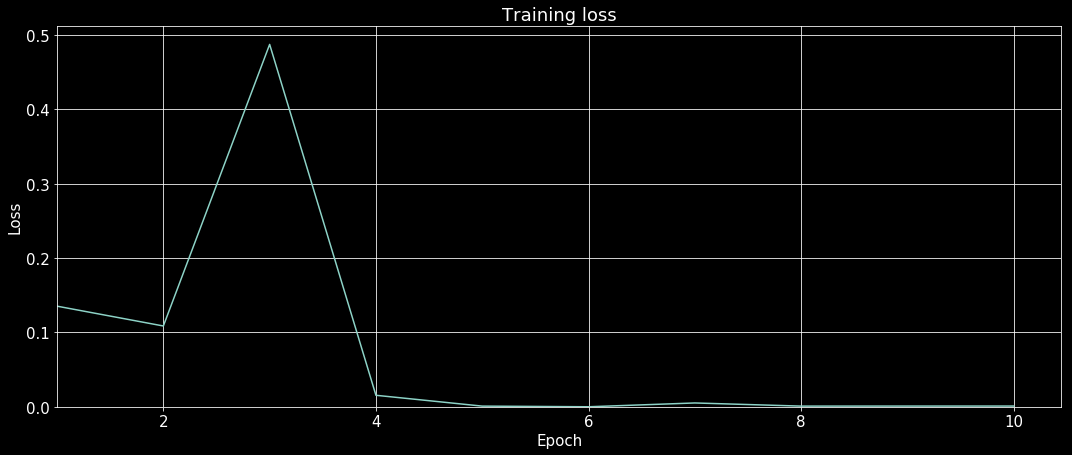

In [17]:
losses = trainLoop(mnist_model,train_loader,optimizer,trainOnBatch,epochs=epochs,scheduler=scheduler)